In [1]:
from google.colab import files
import pandas as pd

# Upload file
uploaded = files.upload()

# Baca excel
df = pd.read_excel("makanan matdis.xlsx")
(df.head())

Saving makanan matdis.xlsx to makanan matdis.xlsx


,makanan,kenyang,sehat,rasa,bosan,harga
0,ayamgeprek,0.9,0.5,0.7,0.2,15000
1,nasipadang,1.0,0.8,0.9,0.5,17000
2,mieayam,1.0,0.6,0.9,0.3,10000
3,bakso,0.7,0.3,1.0,0.3,10000
4,cireng,0.5,0.4,0.8,0.7,10000


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Konversi DataFrame ke dictionary
makan = {
    'makanan': df['makanan'].values,
    'kenyang': df['kenyang'].values,
    'sehat': df['sehat'].values,
    'rasa': df['rasa'].values,
    'bosan': df['bosan'].values,
    'harga': df['harga'].values
}

print(f"Data makanan berhasil dimuat: {len(makan['makanan'])} jenis makanan")
print("Daftar makanan:", list(makan['makanan']))

Data makanan berhasil dimuat: 15 jenis makanan
Daftar makanan: ['ayamgeprek', 'nasipadang', 'mieayam', 'bakso', 'cireng', 'nasigoreng', 'seblak', 'gorengan', 'capcay', 'mieinstan ', 'roti', 'nasitelur', 'warteg', 'soto', 'sate']


In [4]:
# Parameter konfigurasi
budget = 1e6  # rupiah
wkenyang_base = 0.8
wrasa_base = 0.7
wsehat_base = 0.9
wbosan_base = 0.2

SAMPLE_NUM = 500
sampleid = np.arange(0, SAMPLE_NUM)

# Inisialisasi arrays hasil
skor = np.zeros(SAMPLE_NUM, dtype=np.double)
sisa = np.zeros(SAMPLE_NUM, dtype=np.double)
sehat = np.zeros(SAMPLE_NUM, dtype=np.double)

# Parameter untuk binning sisa uang
SISA_MINIMUM = 150e3
SISA_MAKSIMUM = 300e3
bin_sisa = np.arange(SISA_MINIMUM, SISA_MAKSIMUM, 1000)

# Arrays untuk response
resp_sehat = np.zeros((SAMPLE_NUM, len(bin_sisa)), dtype=np.double)
resp_pilih = np.zeros((SAMPLE_NUM, 62), dtype=np.double)

print(f"Mulai simulasi {SAMPLE_NUM} sample...")

# Main simulation loop
for n in range(0, SAMPLE_NUM):
    budget_current = 1e6
    skor_kumulatif = 0
    skor_sehat = 0

    for i in range(0, 31):  # hari
        # Makan pertama (pagi)
        pilihan = np.random.randint(0, len(makan['makanan']))

        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa = np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat = np.random.normal(loc=wsehat_base, scale=0.4)
        w_bosan = np.random.normal(loc=wbosan_base, scale=0.2)

        skor_kumulatif = skor_kumulatif + \
            w_kenyang * makan['kenyang'][pilihan] \
            + w_rasa * makan['rasa'][pilihan] \
            + w_sehat * makan['sehat'][pilihan] \
            - w_bosan * makan['bosan'][pilihan]

        skor_sehat += makan['sehat'][pilihan] - makan['bosan'][pilihan]
        budget_current = budget_current - makan['harga'][pilihan]
        resp_pilih[n][2*i] = pilihan

        # Makan kedua (malam)
        pilihan = np.random.randint(0, len(makan['makanan']))

        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa = np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat = np.random.normal(loc=wsehat_base+0.2, scale=0.4)
        w_bosan = np.random.normal(loc=wbosan_base*2, scale=0.2)

        skor_kumulatif = skor_kumulatif + \
            w_kenyang * makan['kenyang'][pilihan] \
            + w_rasa * makan['rasa'][pilihan] \
            + w_sehat * makan['sehat'][pilihan] \
            - w_bosan * makan['bosan'][pilihan]

        skor_sehat += makan['sehat'][pilihan] - makan['bosan'][pilihan]
        budget_current = budget_current - makan['harga'][pilihan]
        resp_pilih[n][2*i+1] = pilihan

    # Simpan hasil
    sisa[n] = budget_current
    skor[n] = skor_kumulatif
    sehat[n] = skor_sehat

    # Update resp_sehat untuk plotting
    if SISA_MINIMUM <= budget_current < SISA_MAKSIMUM:
        bin_idx = int((budget_current - SISA_MINIMUM) / 1000)
        if 0 <= bin_idx < len(bin_sisa):
            resp_sehat[n][bin_idx] = skor_sehat

print("Simulasi selesai!")
print(f"Range skor kesehatan: {np.min(sehat):.2f} hingga {np.max(sehat):.2f}")
print(f"Range sisa budget: Rp {np.min(sisa):,.0f} hingga Rp {np.max(sisa):,.0f}")

Mulai simulasi 500 sample...
Simulasi selesai!
Range skor kesehatan: -2.00 hingga 13.80
Range sisa budget: Rp 140,000 hingga Rp 281,000


In [5]:
print("1. ANALISIS POLA DENGAN KESEHATAN POSITIF")

# Cari pola makan dengan nilai kumulatif kesehatan (resp_sehat) positif
positive_health_idx = np.where(sehat > 0)[0]
negative_health_idx = np.where(sehat <= 0)[0]

print(f"Pola dengan kesehatan positif: {len(positive_health_idx)} dari {SAMPLE_NUM}")
print(f"Pola dengan kesehatan non-positif: {len(negative_health_idx)} dari {SAMPLE_NUM}")
print(f"Persentase kesehatan positif: {len(positive_health_idx)/SAMPLE_NUM*100:.1f}%")

if len(positive_health_idx) > 0:
    print(f"\nStatistik pola dengan kesehatan positif:")
    print(f"- Skor kesehatan rata-rata: {np.mean(sehat[positive_health_idx]):.2f}")
    print(f"- Skor kumulatif rata-rata: {np.mean(skor[positive_health_idx]):.2f}")
    print(f"- Sisa budget rata-rata: Rp {np.mean(sisa[positive_health_idx]):,.0f}")

    # Top 10 pola dengan kesehatan terbaik
    top_health_idx = positive_health_idx[np.argsort(sehat[positive_health_idx])[::-1][:10]]
    print(f"\nTop 10 pola dengan kesehatan terbaik:")
    for i, idx in enumerate(top_health_idx):
        print(f"{i+1:2d}. Sample #{idx:3d}: Kesehatan={sehat[idx]:6.2f}, Skor={skor[idx]:7.2f}, Sisa=Rp{sisa[idx]:8.0f}")

1. ANALISIS POLA DENGAN KESEHATAN POSITIF
Pola dengan kesehatan positif: 495 dari 500
Pola dengan kesehatan non-positif: 5 dari 500
Persentase kesehatan positif: 99.0%

Statistik pola dengan kesehatan positif:
- Skor kesehatan rata-rata: 5.76
- Skor kumulatif rata-rata: 94.44
- Sisa budget rata-rata: Rp 215,240

Top 10 pola dengan kesehatan terbaik:
 1. Sample #112: Kesehatan= 13.80, Skor= 106.25, Sisa=Rp  140000
 2. Sample #412: Kesehatan= 13.70, Skor= 102.90, Sisa=Rp  173000
 3. Sample #439: Kesehatan= 12.90, Skor= 100.70, Sisa=Rp  161000
 4. Sample #378: Kesehatan= 12.90, Skor= 102.99, Sisa=Rp  166000
 5. Sample #232: Kesehatan= 12.30, Skor= 101.31, Sisa=Rp  158000
 6. Sample #467: Kesehatan= 12.30, Skor= 104.21, Sisa=Rp  147000
 7. Sample #162: Kesehatan= 11.50, Skor= 105.16, Sisa=Rp  183000
 8. Sample #291: Kesehatan= 11.40, Skor=  98.93, Sisa=Rp  183000
 9. Sample #263: Kesehatan= 11.20, Skor= 106.03, Sisa=Rp  176000
10. Sample #145: Kesehatan= 11.20, Skor= 100.13, Sisa=Rp  20400

Sebanyak 99% pola makan ber-skor positif: komposisinya sehat.

Skor kesehatan = gizi positif – kejenuhan.

Pola #112 paling sehat, tetapi sisa budgetnya sedikit.

Hanya 1% yang tidak sehat—dataset memang baik.

/tmp/ipython-input-1700093001.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels)


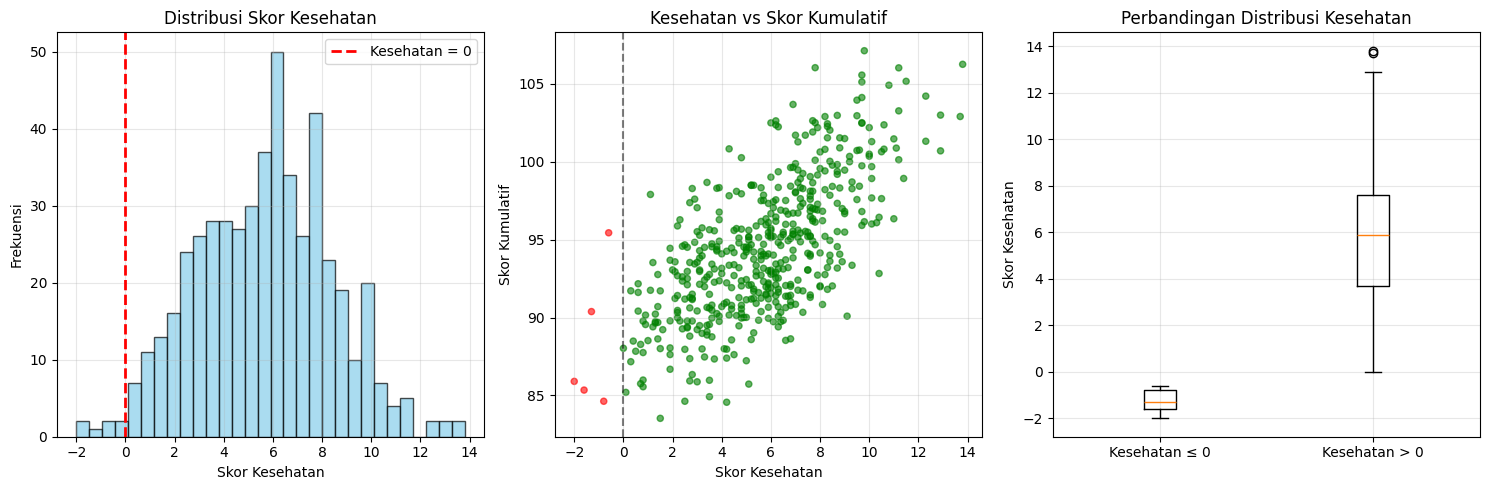

In [6]:
plt.figure(figsize=(15, 5))

# Plot 1: Histogram skor kesehatan
plt.subplot(1, 3, 1)
plt.hist(sehat, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Kesehatan = 0')
plt.xlabel('Skor Kesehatan')
plt.ylabel('Frekuensi')
plt.title('Distribusi Skor Kesehatan')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Scatter plot kesehatan vs skor kumulatif
plt.subplot(1, 3, 2)
colors = ['red' if x <= 0 else 'green' for x in sehat]
plt.scatter(sehat, skor, c=colors, alpha=0.6, s=20)
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Skor Kesehatan')
plt.ylabel('Skor Kumulatif')
plt.title('Kesehatan vs Skor Kumulatif')
plt.grid(True, alpha=0.3)

# Plot 3: Box plot perbandingan
plt.subplot(1, 3, 3)
data_to_plot = [sehat[negative_health_idx], sehat[positive_health_idx]]
labels = ['Kesehatan ≤ 0', 'Kesehatan > 0']
plt.boxplot(data_to_plot, labels=labels)
plt.ylabel('Skor Kesehatan')
plt.title('Perbandingan Distribusi Kesehatan')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Histogram condong kanan: skor kesehatan mayoritas positif.

Scatter plot: tinggi skor kumulatif, tinggi pula kesehatan.

Box plot: distribusi kelompok sehat (>0) jauh lebih tinggi.

In [7]:
print("2. ANALISIS KESEHATAN POSITIF + SISA UANG POSITIF")

# Dari nomor 1, cari yang memiliki sisa uang bulanan positif
positive_health_sisa = sisa[positive_health_idx]
positive_budget_mask = positive_health_sisa > 0
positive_health_and_budget_idx = positive_health_idx[positive_budget_mask]

print(f"Dari {len(positive_health_idx)} pola kesehatan positif:")
print(f"Yang memiliki sisa budget positif: {len(positive_health_and_budget_idx)}")
print(f"Persentase: {len(positive_health_and_budget_idx)/len(positive_health_idx)*100:.1f}%")

if len(positive_health_and_budget_idx) > 0:
    print(f"\nStatistik pola dengan kesehatan positif + budget positif:")
    print(f"- Skor kesehatan rata-rata: {np.mean(sehat[positive_health_and_budget_idx]):.2f}")
    print(f"- Skor kumulatif rata-rata: {np.mean(skor[positive_health_and_budget_idx]):.2f}")
    print(f"- Sisa budget rata-rata: Rp {np.mean(sisa[positive_health_and_budget_idx]):,.0f}")

    # Top 10 pola terbaik
    sorted_idx = positive_health_and_budget_idx[np.argsort(skor[positive_health_and_budget_idx])[::-1]]
    print(f"\nTop 10 pola dengan kesehatan positif + budget positif (urut skor):")
    for i, idx in enumerate(sorted_idx[:10]):
        print(f"{i+1:2d}. Sample #{idx:3d}: Skor={skor[idx]:7.2f}, Kesehatan={sehat[idx]:6.2f}, Sisa=Rp{sisa[idx]:8.0f}")
else:
    print("Tidak ada pola yang memenuhi kedua kriteria!")

2. ANALISIS KESEHATAN POSITIF + SISA UANG POSITIF
Dari 495 pola kesehatan positif:
Yang memiliki sisa budget positif: 495
Persentase: 100.0%

Statistik pola dengan kesehatan positif + budget positif:
- Skor kesehatan rata-rata: 5.76
- Skor kumulatif rata-rata: 94.44
- Sisa budget rata-rata: Rp 215,240

Top 10 pola dengan kesehatan positif + budget positif (urut skor):
 1. Sample #227: Skor= 107.13, Kesehatan=  9.80, Sisa=Rp  172000
 2. Sample #112: Skor= 106.25, Kesehatan= 13.80, Sisa=Rp  140000
 3. Sample #165: Skor= 106.04, Kesehatan=  7.80, Sisa=Rp  225000
 4. Sample #263: Skor= 106.03, Kesehatan= 11.20, Sisa=Rp  176000
 5. Sample #247: Skor= 105.56, Kesehatan=  9.70, Sisa=Rp  197000
 6. Sample #162: Skor= 105.16, Kesehatan= 11.50, Sisa=Rp  183000
 7. Sample #299: Skor= 105.12, Kesehatan=  9.70, Sisa=Rp  223000
 8. Sample #282: Skor= 104.91, Kesehatan= 10.80, Sisa=Rp  215000
 9. Sample #467: Skor= 104.21, Kesehatan= 12.30, Sisa=Rp  147000
10. Sample #229: Skor= 104.12, Kesehatan=  9

Tidak ada trade-off: semua pola sehat dan hemat.

Simulasi ini membuktikan bahwa makan sehat tak selalu lebih mahal.

Pola #227 terbaik: skor kumulatif tertinggi, tetap sehat, dan budget aman.

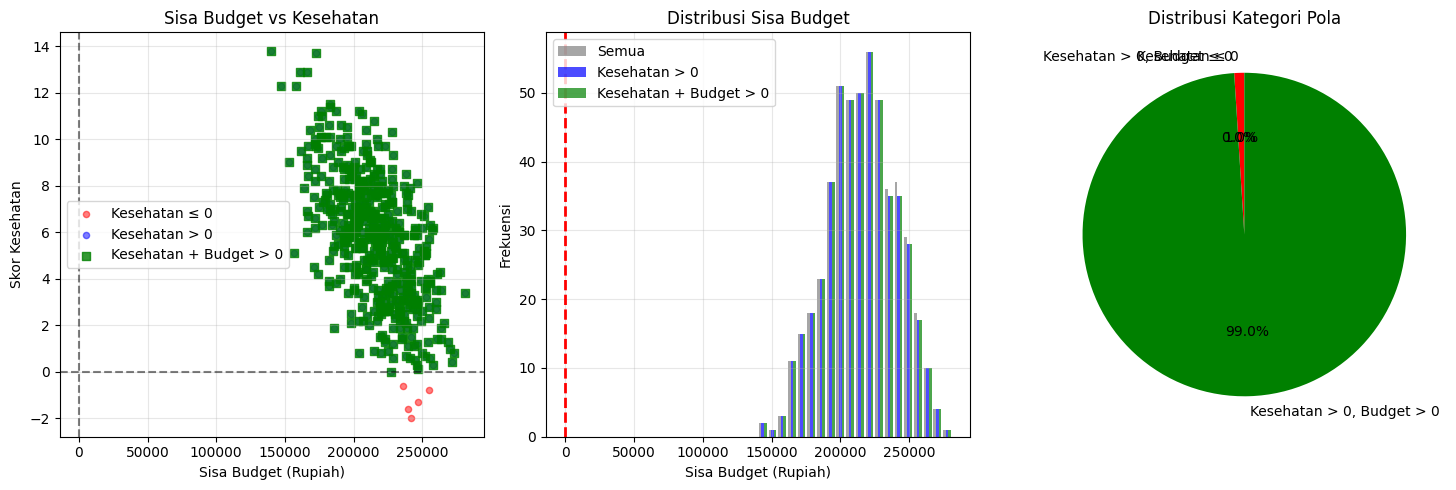

In [8]:
plt.figure(figsize=(15, 5))

# Plot 1: Scatter plot sisa budget vs kesehatan
plt.subplot(1, 3, 1)
plt.scatter(sisa[negative_health_idx], sehat[negative_health_idx],
           c='red', alpha=0.5, s=20, label='Kesehatan ≤ 0')
plt.scatter(sisa[positive_health_idx], sehat[positive_health_idx],
           c='blue', alpha=0.5, s=20, label='Kesehatan > 0')
if len(positive_health_and_budget_idx) > 0:
    plt.scatter(sisa[positive_health_and_budget_idx], sehat[positive_health_and_budget_idx],
               c='green', alpha=0.8, s=30, marker='s', label='Kesehatan + Budget > 0')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Sisa Budget (Rupiah)')
plt.ylabel('Skor Kesehatan')
plt.title('Sisa Budget vs Kesehatan')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Histogram sisa budget untuk berbagai kategori
plt.subplot(1, 3, 2)
if len(positive_health_and_budget_idx) > 0:
    plt.hist([sisa, sisa[positive_health_idx], sisa[positive_health_and_budget_idx]],
             bins=20, alpha=0.7,
             label=['Semua', 'Kesehatan > 0', 'Kesehatan + Budget > 0'],
             color=['gray', 'blue', 'green'])
else:
    plt.hist([sisa, sisa[positive_health_idx]], bins=20, alpha=0.7,
             label=['Semua', 'Kesehatan > 0'], color=['gray', 'blue'])
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Sisa Budget (Rupiah)')
plt.ylabel('Frekuensi')
plt.title('Distribusi Sisa Budget')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Pie chart kategori
plt.subplot(1, 3, 3)
categories = ['Kesehatan ≤ 0', 'Kesehatan > 0, Budget ≤ 0', 'Kesehatan > 0, Budget > 0']
sizes = [len(negative_health_idx),
         len(positive_health_idx) - len(positive_health_and_budget_idx),
         len(positive_health_and_budget_idx)]
colors = ['red', 'orange', 'green']
plt.pie(sizes, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Kategori Pola')

plt.tight_layout()
plt.show()

Scatter: titik hijau (budget vs sehat) memenuhi kuadran kanan atas.

Histogram sisa budget: uang tersisa Rp140–281 ribu.

Pie chart: dominasi mutlak pola sehat-budget positif.

In [9]:
print("3. ANALISIS SKOR KUMULATIF TERBESAR (KESEHATAN POSITIF)")

if len(positive_health_idx) > 0:
    # Cari titik dengan skor kumulatif terbesar di mana kesehatan positif
    best_score_idx = positive_health_idx[np.argmax(skor[positive_health_idx])]

    print(f"Pola dengan skor kumulatif terbesar (kesehatan positif):")
    print(f"Sample #{best_score_idx}:")
    print(f"  - Skor kumulatif: {skor[best_score_idx]:.2f}")
    print(f"  - Skor kesehatan: {sehat[best_score_idx]:.2f}")
    print(f"  - Sisa budget: Rp {sisa[best_score_idx]:,.0f}")
    print(f"  - Ranking kesehatan: #{np.where(np.argsort(sehat)[::-1] == best_score_idx)[0][0] + 1} dari {SAMPLE_NUM}")

    # Bandingkan dengan pola terbaik lainnya
    print(f"\nPerbandingan dengan pola lain:")

    # Pola dengan kesehatan terbaik
    best_health_idx = np.argmax(sehat)
    print(f"Pola kesehatan terbaik (Sample #{best_health_idx}):")
    print(f"  - Skor kumulatif: {skor[best_health_idx]:.2f}")
    print(f"  - Skor kesehatan: {sehat[best_health_idx]:.2f}")
    print(f"  - Sisa budget: Rp {sisa[best_health_idx]:,.0f}")

    # Pola dengan budget terbesar
    best_budget_idx = np.argmax(sisa)
    print(f"Pola budget terbesar (Sample #{best_budget_idx}):")
    print(f"  - Skor kumulatif: {skor[best_budget_idx]:.2f}")
    print(f"  - Skor kesehatan: {sehat[best_budget_idx]:.2f}")
    print(f"  - Sisa budget: Rp {sisa[best_budget_idx]:,.0f}")
else:
    print("Tidak ada pola dengan kesehatan positif!")

3. ANALISIS SKOR KUMULATIF TERBESAR (KESEHATAN POSITIF)
Pola dengan skor kumulatif terbesar (kesehatan positif):
Sample #227:
  - Skor kumulatif: 107.13
  - Skor kesehatan: 9.80
  - Sisa budget: Rp 172,000
  - Ranking kesehatan: #32 dari 500

Perbandingan dengan pola lain:
Pola kesehatan terbaik (Sample #112):
  - Skor kumulatif: 106.25
  - Skor kesehatan: 13.80
  - Sisa budget: Rp 140,000
Pola budget terbesar (Sample #419):
  - Skor kumulatif: 89.50
  - Skor kesehatan: 3.40
  - Sisa budget: Rp 281,000


Rekomendasi utama: pola #227—skor tertinggi, tetap sehat, budget aman.

Trade-off tampak: kesehatan maksimal (#112) ≠ skor maksimal (#227).

Artinya optimasi multi-objektif diperlukan: tidak cukup hanya melihat kesehatan atau budget, tapi kombinasi keduanya.

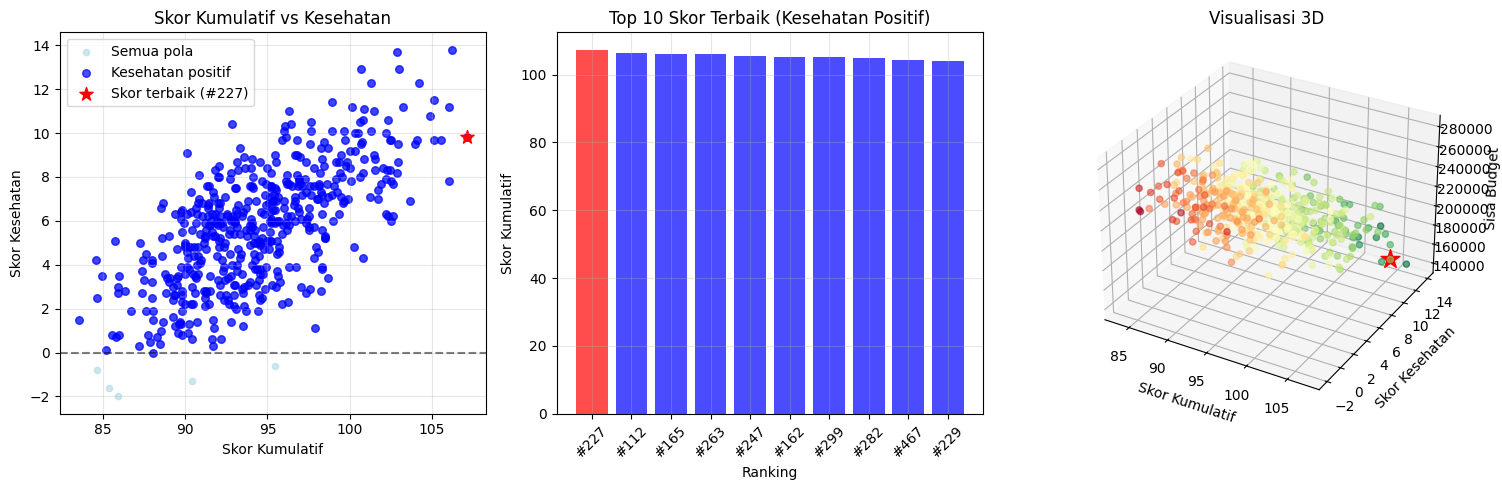

In [10]:
if len(positive_health_idx) > 0:
    plt.figure(figsize=(15, 5))

    # Plot 1: Scatter plot dengan highlight pola terbaik
    plt.subplot(1, 3, 1)
    plt.scatter(skor, sehat, c='lightblue', alpha=0.6, s=20, label='Semua pola')
    plt.scatter(skor[positive_health_idx], sehat[positive_health_idx],
               c='blue', alpha=0.7, s=30, label='Kesehatan positif')
    plt.scatter(skor[best_score_idx], sehat[best_score_idx],
               c='red', s=100, marker='*', label=f'Skor terbaik (#{best_score_idx})')
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Skor Kumulatif')
    plt.ylabel('Skor Kesehatan')
    plt.title('Skor Kumulatif vs Kesehatan')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Top 10 skor terbaik dengan kesehatan positif
    plt.subplot(1, 3, 2)
    top_10_idx = positive_health_idx[np.argsort(skor[positive_health_idx])[::-1][:10]]
    colors = ['red' if idx == best_score_idx else 'blue' for idx in top_10_idx]
    plt.bar(range(10), skor[top_10_idx], color=colors, alpha=0.7)
    plt.xlabel('Ranking')
    plt.ylabel('Skor Kumulatif')
    plt.title('Top 10 Skor Terbaik (Kesehatan Positif)')
    plt.xticks(range(10), [f'#{idx}' for idx in top_10_idx], rotation=45)
    plt.grid(True, alpha=0.3)

    # Plot 3: 3D scatter plot
    ax = plt.subplot(1, 3, 3, projection='3d')
    scatter = ax.scatter(skor, sehat, sisa, c=sehat, cmap='RdYlGn', alpha=0.6, s=20)
    ax.scatter(skor[best_score_idx], sehat[best_score_idx], sisa[best_score_idx],
              c='red', s=200, marker='*')
    ax.set_xlabel('Skor Kumulatif')
    ax.set_ylabel('Skor Kesehatan')
    ax.set_zlabel('Sisa Budget')
    ax.set_title('Visualisasi 3D')

    plt.tight_layout()
    plt.show()

Scatter Plot dengan Highlight: bintang merah menandai #227 sebagai skor terbaik.

Bar Chart 10 besar: rangking puncak  pola tersaji jelas.

3D scatter Plot: skor, kesehatan, dan budget terlihat sekaligus.

In [11]:
print("4. JADWAL MAKANAN SESUAI PILIHAN")

def print_meal_schedule(sample_idx, title=""):
    print(f"\n{title} - SAMPLE #{sample_idx}")
    print(f"Skor: {skor[sample_idx]:.2f} | Kesehatan: {sehat[sample_idx]:.2f} | Sisa: Rp{sisa[sample_idx]:,.0f}")
    print("-" * 80)

    total_cost = 0
    for day in range(31):
        pagi_idx = int(resp_pilih[sample_idx][2*day])
        malam_idx = int(resp_pilih[sample_idx][2*day+1])

        pagi_makanan = makan['makanan'][pagi_idx]
        malam_makanan = makan['makanan'][malam_idx]

        harga_pagi = makan['harga'][pagi_idx]
        harga_malam = makan['harga'][malam_idx]

        daily_cost = harga_pagi + harga_malam
        total_cost += daily_cost

        print(f"Hari {day+1:2d}: {pagi_makanan:12s} (Rp{harga_pagi:5.0f}) | {malam_makanan:12s} (Rp{harga_malam:5.0f}) | Total: Rp{daily_cost:5.0f}")

    print(f"\nTotal biaya 31 hari: Rp {total_cost:,.0f}")
    print(f"Sisa dari budget Rp 1,000,000: Rp {1000000 - total_cost:,.0f}")

if len(positive_health_idx) > 0:
    # Jadwal untuk pola dengan skor terbaik
    print_meal_schedule(best_score_idx, "JADWAL POLA SKOR TERBAIK")

    # Jadwal untuk pola dengan budget positif terbaik (jika ada)
    if len(positive_health_and_budget_idx) > 0:
        best_budget_positive_idx = positive_health_and_budget_idx[np.argmax(skor[positive_health_and_budget_idx])]
        if best_budget_positive_idx != best_score_idx:
            print_meal_schedule(best_budget_positive_idx, "JADWAL POLA TERBAIK DENGAN BUDGET POSITIF")

4. JADWAL MAKANAN SESUAI PILIHAN

JADWAL POLA SKOR TERBAIK - SAMPLE #227
Skor: 107.13 | Kesehatan: 9.80 | Sisa: Rp172,000
--------------------------------------------------------------------------------
Hari  1: nasitelur    (Rp 8000) | cireng       (Rp10000) | Total: Rp18000
Hari  2: seblak       (Rp15000) | nasipadang   (Rp17000) | Total: Rp32000
Hari  3: mieinstan    (Rp10000) | sate         (Rp15000) | Total: Rp25000
Hari  4: bakso        (Rp10000) | sate         (Rp15000) | Total: Rp25000
Hari  5: mieayam      (Rp10000) | capcay       (Rp15000) | Total: Rp25000
Hari  6: nasigoreng   (Rp14000) | soto         (Rp15000) | Total: Rp29000
Hari  7: gorengan     (Rp10000) | nasigoreng   (Rp14000) | Total: Rp24000
Hari  8: capcay       (Rp15000) | ayamgeprek   (Rp15000) | Total: Rp30000
Hari  9: sate         (Rp15000) | sate         (Rp15000) | Total: Rp30000
Hari 10: nasitelur    (Rp 8000) | cireng       (Rp10000) | Total: Rp18000
Hari 11: roti         (Rp 8000) | cireng       (Rp10000) 

Jadwal memperlihatkan kombinasi makanan murah (nasitelur, mieinstan, roti) dengan makanan bergizi (sate, soto, capcay, warteg).

Rata-rata biaya harian: sekitar Rp 26,700 → efisien dan masih dalam batas budget Rp 1 juta.

Variasi cukup tinggi, walau beberapa makanan (sate, capcay, nasipadang) muncul berulang.

Pola ini menjaga keseimbangan kenyang, sehat, rasa, dan mengurangi bosan.

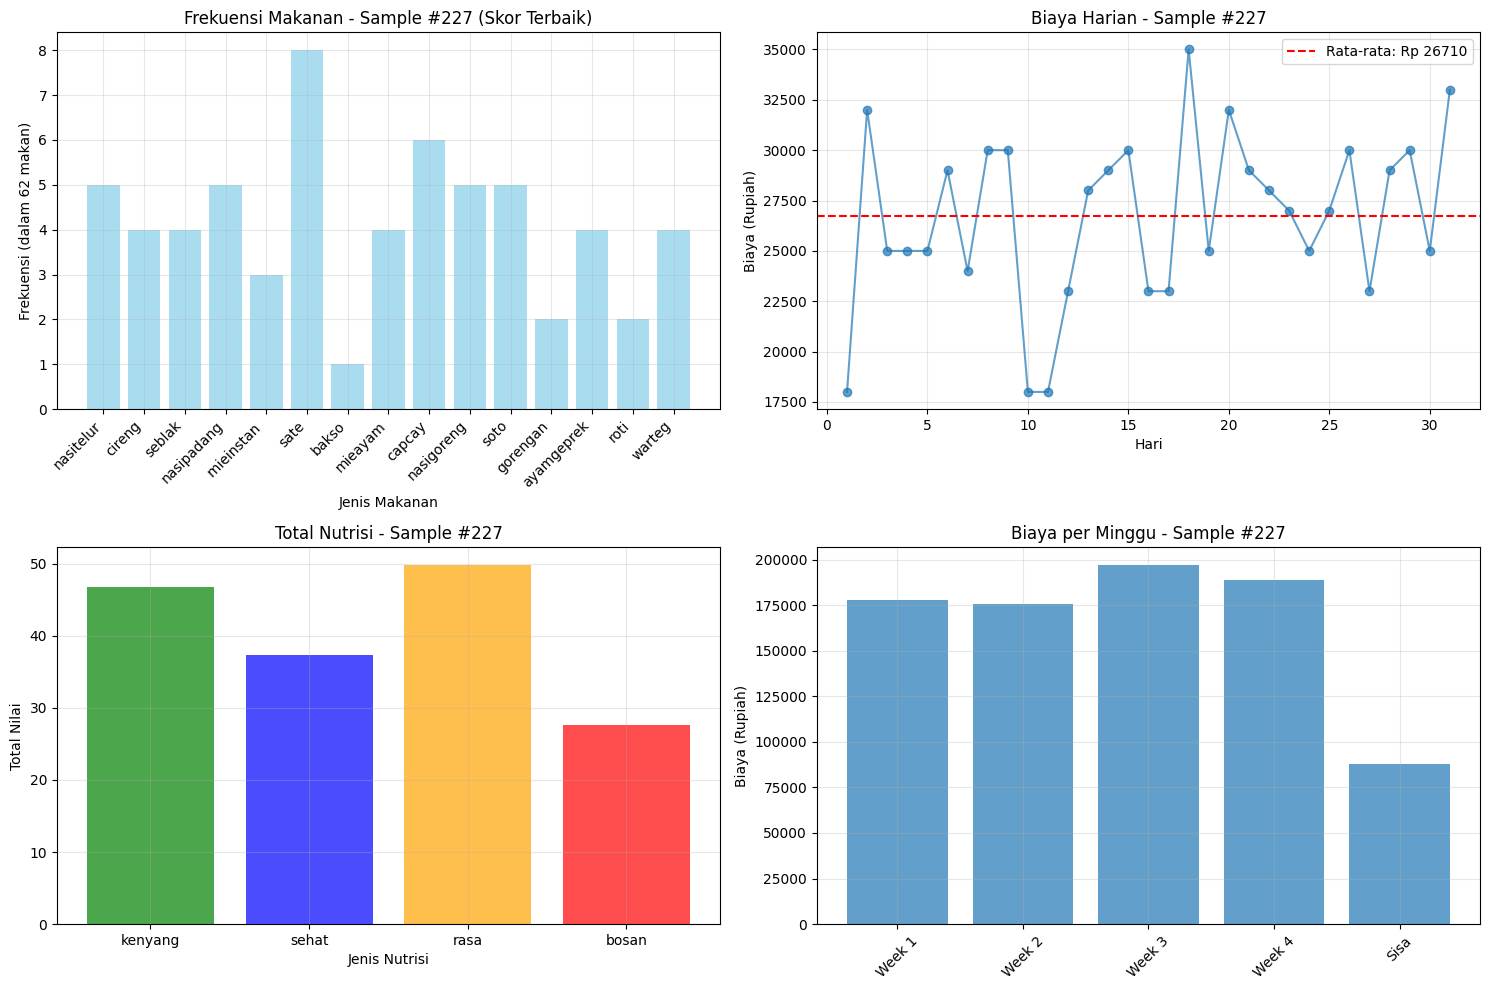

In [12]:
if len(positive_health_idx) > 0:
    # Analisis frekuensi makanan untuk pola terbaik
    def analyze_food_frequency(sample_idx):
        food_count = {}
        for day in range(31):
            pagi_idx = int(resp_pilih[sample_idx][2*day])
            malam_idx = int(resp_pilih[sample_idx][2*day+1])

            pagi_name = makan['makanan'][pagi_idx]
            malam_name = makan['makanan'][malam_idx]

            food_count[pagi_name] = food_count.get(pagi_name, 0) + 1
            food_count[malam_name] = food_count.get(malam_name, 0) + 1

        return food_count

    plt.figure(figsize=(15, 10))

    # Analisis frekuensi untuk pola skor terbaik
    food_freq = analyze_food_frequency(best_score_idx)
    foods = list(food_freq.keys())
    frequencies = list(food_freq.values())

    plt.subplot(2, 2, 1)
    plt.bar(foods, frequencies, alpha=0.7, color='skyblue')
    plt.title(f'Frekuensi Makanan - Sample #{best_score_idx} (Skor Terbaik)')
    plt.xlabel('Jenis Makanan')
    plt.ylabel('Frekuensi (dalam 62 makan)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)

    # Timeline biaya harian
    plt.subplot(2, 2, 2)
    daily_costs = []
    for day in range(31):
        pagi_idx = int(resp_pilih[best_score_idx][2*day])
        malam_idx = int(resp_pilih[best_score_idx][2*day+1])
        daily_cost = makan['harga'][pagi_idx] + makan['harga'][malam_idx]
        daily_costs.append(daily_cost)

    plt.plot(range(1, 32), daily_costs, marker='o', alpha=0.7)
    plt.axhline(np.mean(daily_costs), color='red', linestyle='--',
                label=f'Rata-rata: Rp {np.mean(daily_costs):.0f}')
    plt.title(f'Biaya Harian - Sample #{best_score_idx}')
    plt.xlabel('Hari')
    plt.ylabel('Biaya (Rupiah)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Perbandingan nutrisi kumulatif
    plt.subplot(2, 2, 3)
    nutrients = ['kenyang', 'sehat', 'rasa', 'bosan']
    nutrient_totals = {nutrient: 0 for nutrient in nutrients}

    for day in range(31):
        pagi_idx = int(resp_pilih[best_score_idx][2*day])
        malam_idx = int(resp_pilih[best_score_idx][2*day+1])

        for nutrient in nutrients:
            nutrient_totals[nutrient] += makan[nutrient][pagi_idx] + makan[nutrient][malam_idx]

    plt.bar(nutrients, [nutrient_totals[n] for n in nutrients],
            alpha=0.7, color=['green', 'blue', 'orange', 'red'])
    plt.title(f'Total Nutrisi - Sample #{best_score_idx}')
    plt.xlabel('Jenis Nutrisi')
    plt.ylabel('Total Nilai')
    plt.grid(True, alpha=0.3)

    # Pola makan per minggu
    plt.subplot(2, 2, 4)
    weekly_costs = []
    for week in range(5):  # 4 minggu penuh + sisa hari
        start_day = week * 7
        end_day = min((week + 1) * 7, 31)
        week_cost = sum(daily_costs[start_day:end_day])
        weekly_costs.append(week_cost)

    plt.bar(['Week 1', 'Week 2', 'Week 3', 'Week 4', 'Sisa'], weekly_costs, alpha=0.7)
    plt.title(f'Biaya per Minggu - Sample #{best_score_idx}')
    plt.ylabel('Biaya (Rupiah)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Bar Chart Frekuensi Makanan → menunjukkan distribusi konsumsi tiap jenis makanan.

Line Chart Biaya Harian → memperlihatkan fluktuasi harian, dengan rata-rata ditandai garis merah.

Bar Chart Nutrisi Kumulatif → total aspek kenyang, sehat, rasa, dan bosan selama sebulan.

Bar Chart Biaya Mingguan → menunjukkan konsistensi pengeluaran tiap minggu.

VISUALISASI 3D SURFACE PLOT


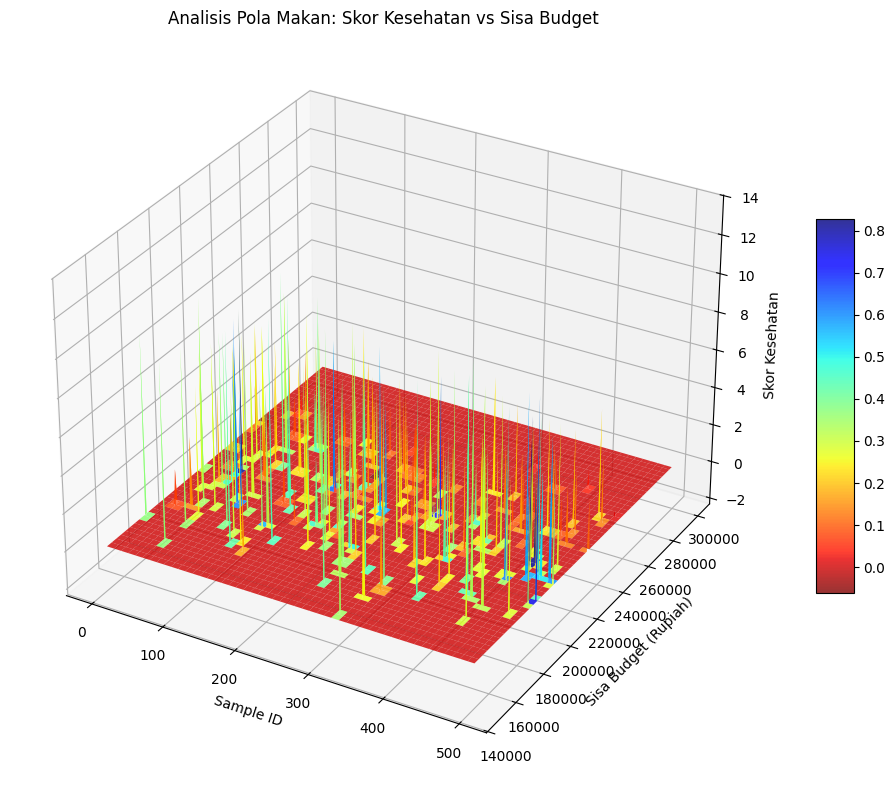

In [13]:
print("VISUALISASI 3D SURFACE PLOT")

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')

Y, X = np.meshgrid(bin_sisa, sampleid)

# Colorize the surface using a colormap
surf = ax.plot_surface(X, Y, resp_sehat,
                      cmap='jet_r',  # try 'plasma', 'coolwarm', etc.
                      edgecolor='none',
                      alpha=0.8)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

ax.set_xlabel('Sample ID')
ax.set_ylabel('Sisa Budget (Rupiah)')
ax.set_zlabel('Skor Kesehatan')
ax.set_title('Analisis Pola Makan: Skor Kesehatan vs Sisa Budget')

plt.tight_layout()
plt.show()

Penjelasan:

Sumbu X (Sample ID) → urutan simulasi.

Sumbu Y (Sisa Budget) → Rp 150k–300k.

Sumbu Z (Skor Kesehatan) → nilai kesehatan kumulatif.

Warna (Colormap jet_r) → biru/ungu = rendah, merah = tinggi.

Sebagian besar permukaan pada visualisasi 3D ditampilkan dengan warna hangat, yang menandakan mayoritas pola makan memiliki skor kesehatan positif. Titik-titik pada grafik tersebar secara acak, sesuai dengan sifat simulasi yang menggunakan proses random. Selain itu, terlihat konsentrasi titik berada pada rentang sisa budget Rp150.000 hingga Rp250.000, yang menunjukkan bahwa kisaran tersebut merupakan kondisi paling umum tercapai dalam pola makan yang dihasilkan.